In [1]:
import copy
from itertools import product
from classification_refined import classify
from processing import *
from readfiles import *
from decision import filter_summary
from subgraphclass import make_solver_summary
from sklearn.model_selection import train_test_split
from classification_refined import *
import networkx as nx
from readfiles import *
from metrics import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from readfiles import corresp_label_file
import time

In [2]:
num = 84  # number of nodes in the graph
tri = int(num * (num + 1) * 0.5)  # we want only the upper diagonal due to symettry of connections
edge_names = ['mean_FA', 'mean_strl', 'num_streamlines']
mat = np.triu_indices(84)
mews = '/home/skapoor/Thesis/gmwcs-solver'
metrics = ['balanced_accuracy', 'accuracy', 'f1_weighted', 'roc_auc_ovr_weighted']

In [3]:
target, feature, edge, solver_node_wts = 'NEOFAC_E', 'num_streamlines', 'fscores','const'
val, thresh, max_num_nodes, per = -0.01, 0, 5, 50 # percentage of features we want to preserve intially
choice, classifier, refit_metric, feature_selection = 'random', 'SVC', 'balanced_accuracy', 'baseline'
baseline_cases, self_loops = set(), False

In [4]:
# note: right now the matrix whole is not scaled, for computing the fscores and correlation coeff it has to be so.
y_train, y_test = computed_subjects(), test_subjects()
#y_train_l, y_test_l = y_train[target].map({'M': 0, 'F': 1}), y_test[target].map({'M': 0, 'F':1})
y_train_l , y_test_l = y_train[target], y_test[target]
X_train = generate_combined_matrix(tri, list(y_train.index))  # need to check indices till here then convert to numpy array
X_test = generate_test_data(tri, y_test.index)
X_train_l, X_test_l = edge_filtering(feature, X_train, X_test)

X, y = X_train_l.append(X_test_l), y_train_l.append(y_test_l)

In [5]:
assert list(X.index) == list(y.index)

In [6]:
skf = StratifiedKFold(n_splits = 5, shuffle =True, random_state = 22)
skf.get_n_splits(X, y)

print(skf)
results_solver = []
avg_thresh, self_loops = False, False
feature_selection = 'solver'
refit_metric = 'balanced_accuracy'
nodes = []
node_names = []
i =0 
for train_index, test_index in skf.split(X, y):
    i+=1

    #print("TRAIN:",len(train_index), train_index, "TEST:", len(test_index),test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    med = y_train.median()
    y_train_l = pd.qcut(y_train, 5, labels=False, retbins=True)[0]
    # we need to pass the non-binned values for effective pearson correlation calc.
    # print('The number of training subjects which are to be removed:', sum(y_train_l == 2))
    y_train_l = y_train_l[y_train_l != 2]
    y_train_l = y_train_l // 3  # binarizing the values by removing the middle quartile
    y_test_l = y_test >= med 
    X_train_l = X_train.loc[y_train_l.index]
    assert list(X_train_l.index) == list(y_train_l.index)
    
    
    case = (classifier, target, choice, edge, feature_selection, feature, per, refit_metric, self_loops)
    # the baseline needs self loops command but the solver does not!
    # drop the diagonal indices from the columns

    if feature_selection == 'solver':
        if i == 1:
            first_run = True
        else:
            first_run = False
        if i< 5:
            keep_files = False
        else:
            keep_files = True
        print('Keeping files:', keep_files)
        X_train_l, X_test_l, arr, index = transform_array(X_train_l, X_test, y_train_l, per, edge)
        assert len(X_train_l) == len(y_train_l)
        assert len(X_test_l) == len(y_test_l)
        # absolute values of pearson correlation are given accordingly in the transform array function
        # index contains the indexes of the top percentile of features
        for idx in range(len(arr)):
            if idx not in index:
                arr.iloc[idx] = 0
        start = time.time()
        X_train_l, X_test_l, output_graph = solver_pub(X_train_l, X_test_l, y_train_l, arr, 
                                                   feature, thresh, val, max_num_nodes, node_wts = solver_node_wts, 
                                                   target = target, edge = edge, 
                                                   keep_files = keep_files, first_run = first_run)
        
        end = time.time()
        print(f'Solver runtime for fold {i}:', end - start)
        nodes.append(list(output_graph.nodes))
        node_names.append(output_graph.node_labels)
        edge_wts = output_graph.edge_weights
        if len(edge_wts) != 0:
            train_res, test_res = cross_validation(classifier, X_train_l, y_train_l, X_test_l, y_test_l,
                                                   metrics, refit_metric)
            # to make the program faster only do this when the solver is actually producing some results
            results_solver.append(
                [classifier, target, choice, edge, feature_selection, feature, len(edge_wts) * 100 / (tri-84),
                 refit_metric, max_num_nodes,
                 len(edge_wts), sum([edge > 0 for edge in edge_wts]) * 100 / len(edge_wts)])
            results_solver[-1].append(thresh)
            for metric in metrics:
                results_solver[-1].extend([round(100*train_res[metric],3)])
            for metric in metrics:
                results_solver[-1].extend([round(100*test_res[metric],3)])
        

StratifiedKFold(n_splits=5, random_state=22, shuffle=True)
Keeping files: False
Selected indices [   3    6   10 ... 3564 3567 3569]
Solver runtime for fold 1: 700.796199798584
Best estimator {'C': 9.6805668900759, 'class_weight': None, 'gamma': 0.002810275497503833, 'kernel': 'rbf'}
Keeping files: False
Selected indices [   1    3    6 ... 3563 3566 3567]
Solver runtime for fold 2: 700.9206006526947
Best estimator {'C': 86.8081494019555, 'class_weight': 'balanced', 'gamma': 0.00011114524287405247, 'kernel': 'rbf'}
Keeping files: False
Selected indices [   3    6   10 ... 3564 3566 3567]
Solver runtime for fold 3: 700.8951277732849
Best estimator {'C': 86.8081494019555, 'class_weight': 'balanced', 'gamma': 0.00011114524287405247, 'kernel': 'rbf'}
Keeping files: False
Selected indices [   1    3    5 ... 3567 3568 3569]
Solver runtime for fold 4: 700.8709378242493
Best estimator {'C': 0.036175345412181, 'class_weight': None, 'gamma': 0.00032096647431455953, 'kernel': 'linear'}
Keeping f

In [7]:
y_train_l

Subject
128127    1
129028    0
129937    1
130013    1
130316    0
         ..
201414    1
202113    1
202719    1
205725    0
208226    1
Name: NEOFAC_E, Length: 136, dtype: int64

In [8]:
len(y_test_l)

40

In [9]:
a = np.sort(np.concatenate(nodes).flat)

d1 = {k-1:v for k,v in corresp_label_file('fs_default.txt').items() if k-1 in np.unique(a)}

d2 = {}
for k,v in zip(range(len(np.unique(a))), np.unique(a)):
    d2[v] = k

for i in range(len(a)):
    a[i] = d2[a[i]]

In [10]:
#plt.hist(a, bins=len(np.unique(a)))

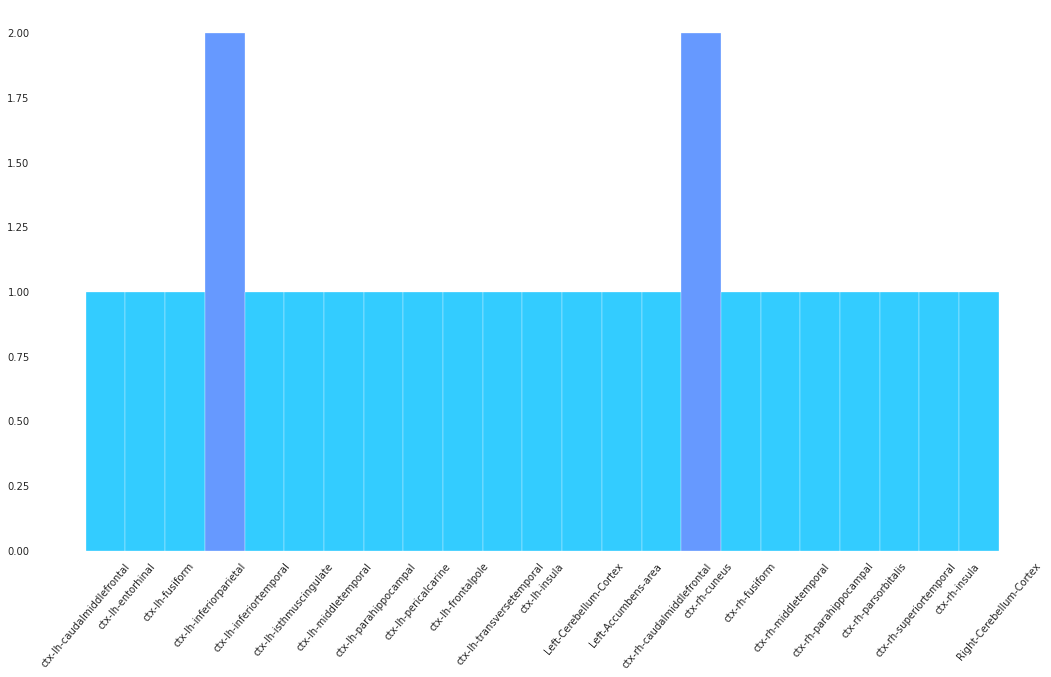

In [11]:
cm = plt.cm.get_cmap('cool')

fig, ax = plt.subplots(figsize=(18,10))
counts, bins, patches = ax.hist(a, bins=len(np.unique(a)))
for c, p in zip(counts, patches):
    plt.setp(p, 'facecolor', cm(c/5))
# Set the ticks to be at the edges of the bins.
plt.xticks(range(len(np.unique(a))),list(d1.values()), rotation=50)
plt.show()

In [12]:
## Parameter settings decided on the basis of thesis

In [13]:
def find_indices(lin):
    """
    Takes a list of indices and finds the corresponding row and column numbers.
    The row and column numbers represent the node number in the LUT.
    
    Parameters:
    lin (int): List of integer indices 
    
    Returns:
    d1 (dict): key-value pair of edges and corresponding nodes
    """
    d1 = {}
    mat = np.triu_indices(84)
    nondiag = list(set(range(3570)).difference(set(diag_flattened_indices(84))))
    for idx in lin: 
        for i in range(len(mat[0])):
            if i == idx:
                d1[idx] = (mat[0][i], mat[1][i])
    return d1

In [14]:
ip = BrainGraph('fscores', 'num_streamlines', 'const', 'Gender', 10, -0.01, 0)
feature_indices = ip.read_from_file(mews, False)
#ip.visualize_graph(mews, False, plotting_options=graph_options('red',10, 'yellow', 2, 1.5),
#                   figs=(10,6))
G = ip

In [15]:
feature_indices

In [16]:
num_strls = X

In [17]:
d1 = find_indices(feature_indices)
ew = G.edge_weights

TypeError: 'NoneType' object is not iterable

In [ ]:
G.edges

In [ ]:
num_strls.columns = num_strls.columns - 2*3570

In [ ]:
num_strls

In [ ]:
tups = []
nums = []
d1 = find_indices(feature_indices)
for edge, index in zip(G.edges, feature_indices):
    tups.append((edge[0], edge[1], num_strls.loc[:, index].mean()))
    nums.append(num_strls.loc[:, index].mean())

In [ ]:
G.add_weighted_edges_from(tups)

In [ ]:
import matplotlib.cm as cm

In [ ]:
minima = min(nums)
maxima = max(nums)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima)
mapper = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('Spectral'))
color = []
for v in nums:
    color.append(mapper.to_rgba(v))
    
    
n = len(G.nodes)
node_list = list(G.nodes)
angle = []
angle_dict = {}
for i, node in zip(range(n),node_list):
    theta = 2.0*np.pi*i/n
    angle.append((np.cos(theta),np.sin(theta)))
    angle_dict[node] = theta
pos = {}
for node_i, node in enumerate(node_list):
    pos[node] = angle[node_i]

labels = {}
for node, i in zip(G.nodes, range(len(G.nodes))):
    labels[node] = G.node_labels[i]
# figsize is intentionally set small to condense the graph
fig, ax = plt.subplots(figsize=(11.5,10))
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
ax.axis('equal')

nx.draw(G,pos=pos,with_labels=False, ax=ax, edge_color=color, edge_cmap=mapper.cmap, vmin=minima,
                        vmax=maxima, width=[i*20 for i in ew], rotate=60)
description = nx.draw_networkx_labels(G,pos,labels=labels, font_size=18)

r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    bbdata = bb.transformed(trans)
    radius = 1.2+bbdata.width/2.
    position = (radius*np.cos(angle_dict[node]),radius* np.sin(angle_dict[node]))
    t.set_position(position)
    t.set_rotation(angle_dict[node]*360.0/(2.0*np.pi))
    t.set_clip_on(False)
cbaxes = fig.add_axes([0.001, 0.4, 0.03, 0.2])  # This is the position for the colorbar
cb = plt.colorbar(mapper, cax = cbaxes)
plt.savefig('outputs/figures/solver_10nodes_strls.png')
plt.show()